In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import math as math
import time

In [2]:
def func(X, noise_std=0.01):
    Y = -torch.sin(6*math.pi*X)**2+6*X**2-5*X**4+3/2

    noise = torch.randn_like(X) * noise_std
    return Y + noise



# Data
X = torch.tensor(np.linspace(0, 1, 30))
y = func(X)


kernel = gp.kernels.Periodic(input_dim=1)

# Set the priors for the kernel parameters
kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.15, 1))  # (0.2, 1)
kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.05, 0.3))   # (0.05, 0.3)

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01)) # the noise N(0,0.01)


total_log_pred_likelihood_list = []

for k in range(20):
    # Use clone for splitting data and ensure requires_grad is set
    current_time = int(time.time())
    X_train, X_test, y_train, y_test = train_test_split(X.clone(), y.clone(), test_size=1/3, random_state=current_time)

    kernel = gp.kernels.Periodic(input_dim=1)

    # Set the priors for the kernel parameters
    kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.2, 1))  # (0.2, 1)
    kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.05, 0.3))   # (0.05, 0.3)


    # Usage
    gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

    # NUTS to sample from posterior
    nuts_kernel = pyro.infer.NUTS(gpr.model)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=2000, num_chains=2, warmup_steps=500) #tuning for warmup_steps
    mcmc.run()

    samples = mcmc.get_samples()

    # Extract samples for each parameter
    lengthscale_samples = samples['kernel.lengthscale']
    variance_samples = samples['kernel.variance']
    # If there are other parameters, extract them similarly

    # Assuming you want 500 random samples
    num_samples = 500
    selected_indices = np.random.choice(lengthscale_samples.shape[0], num_samples, replace=True)

    # Initialize a list to store likelihoods for each sample
    likelihoods = []

    for idx in selected_indices:
        # Set the sampled parameters to your model
        gpr.kernel.lengthscale = lengthscale_samples[idx]
        gpr.kernel.variance = variance_samples[idx]
        # Set other parameters as needed

        # Predict on the test set
        with torch.no_grad():
            mean, variance = gpr(X_test, full_cov=False)

        # Compute likelihood (assuming Gaussian likelihood)
        test_likelihood = -0.5 * torch.log(2 * math.pi * variance) - 0.5 * (y_test - mean) ** 2 / variance
        likelihoods.append(test_likelihood.mean())


    # Compute the average likelihood across all samples
    average_likelihood = torch.mean(torch.stack(likelihoods))
    total_log_pred_likelihood_list.append(average_likelihood)
    print(k)

Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

0


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

1


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

2


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

3


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

4


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

5


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

6


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

7


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

8


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

9


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

10


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

11


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

12


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

13


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

14


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

15


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

16


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

17


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

18


Warmup [1]:   0%|          | 0/2500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2500 [00:00, ?it/s]

19


In [3]:
print(np.mean(total_log_pred_likelihood_list),np.std(total_log_pred_likelihood_list))

-2.6439330919925093 2.5715943387041222


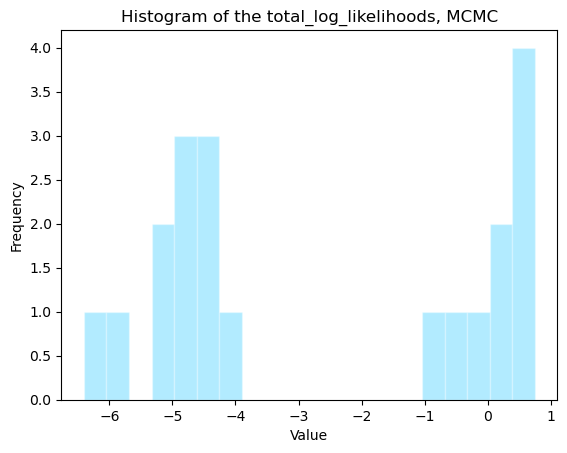

In [4]:
import matplotlib.pyplot as plt
# Creating a histogram
plt.hist(total_log_pred_likelihood_list, bins=20, alpha=0.3, color='deepskyblue', edgecolor='white')

# Adding labels and title for clarity
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the total_log_likelihoods, MCMC')

# Display the histogram
plt.show()